In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from netcal.metrics import ECE

import random

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs
from utils_conformal import conformalize_anytime_nn

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Figure 1

In [26]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [27]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [15]:
# random.seed(0)

# for _ in range(5):
#     samples = random.sample(range(10000), 10)
#     print(samples)
#     for i in samples:
#         # probs_i = probs[:, i, preds[L - 1][i]].cpu()
#         probs_i = probs[:, i, targets[i]].cpu()
#         plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.show()

In [16]:
# # # ground-truth probs
# for i in [1528, 6534, 18, 8086, 5458, 3996, 5328, 1031, 3130, 9298]:
#     probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

In [11]:
# # modal probs
# for i in [6311, 6890, 663, 4242, 8376, 7961, 6634, 4969, 7808, 5866]:
#     probs_i = probs[:, i, preds[L - 1][i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

{0.01: 67.36999999999999, 0.1: 49.78, 0.2: 41.67, 0.5: 23.150000000000002}


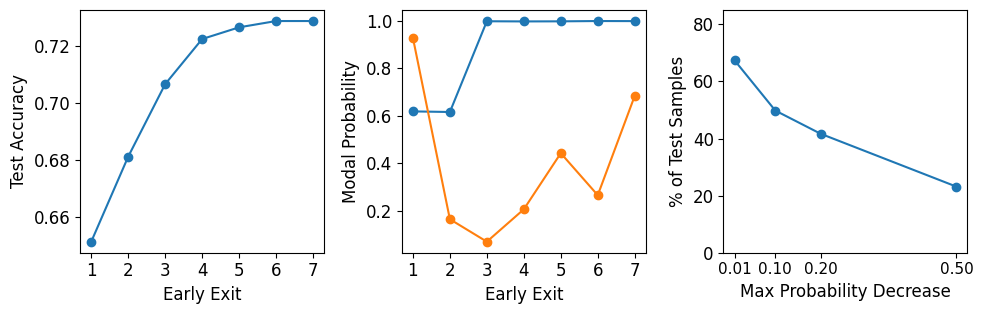

In [21]:
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 3, figsize=(10, 3.3))
early_exits = [i + 1 for i in range(L)]

ax[0].plot(early_exits, acc, label='NN', marker='o')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_xticks(early_exits)

ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i in [6311, 8376]:
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)

THRESHOLDS = [-0.01, -0.1, -0.2, -0.5]
ax[2].set_xlabel('Max Probability Decrease')
ax[2].set_ylabel('% of Test Samples')
if PLOT_TYPE == 'Modal Probability':
    probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)
elif PLOT_TYPE == 'Ground-Truth Probability':
    probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)
print(probs_decrase)
ax[2].plot(probs_decrase.keys(), probs_decrase.values(), marker='o')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax[2].set_xticks(list(probs_decrase.keys()))
ax[2].tick_params(labelsize=11, axis='x')
ax[2].set_ylim([0., 85.])

plt.tight_layout()
# plt.savefig(f'figures/figure_1_{PLOT_TYPE}.pdf', dpi=1200)
plt.show()

TODO: add plot for maximum-softmax-probability decreases

# Figure 2

In [1]:
CIFAR_100_DICT = {"MSDNet": [0.65130, 0.68110, 0.7064, 0.72229, 0.7264, 0.7286, 0.7286000], 
                  "MSDNet PoE-OVR": [0.6513, 0.7027, 0.7343, 0.748, 0.7552, 0.7567, 0.7559], 
                  "IMTA": [0.6222, 0.6685, 0.6966, 0.7143, 0.7189, 0.7216, 0.7226], 
                  "IMTA PoE-OVR": [0.6222, 0.6665, 0.6958, 0.7148, 0.7255, 0.7316, 0.7331]}


IMAGE_NET_DICT = {"MSDNet": [0.5663, 0.6514, 0.6842, 0.6977, 0.7134],
                  "MSDNet PoE-OVR": [0.5663, 0.6508, 0.6867, 0.7022, 0.7138],
                  "DViT": [0.7267, 0.7899, 0.818],
                  "DViT PoE-OVR": [0.7267, 0.7847, 0.816]}


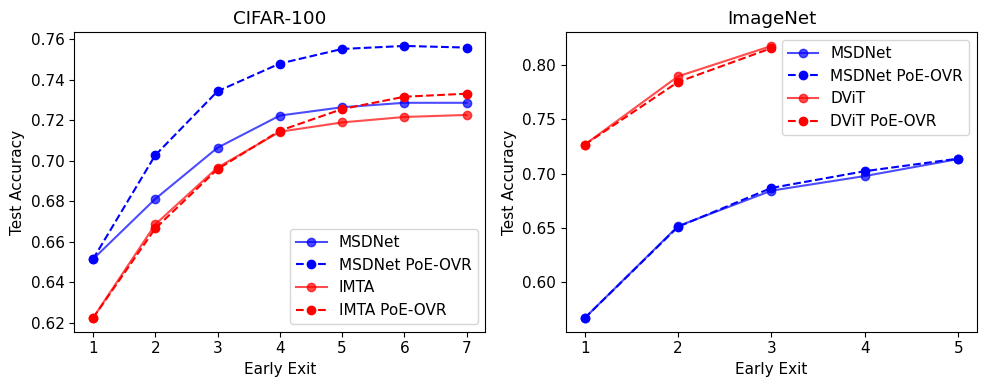

In [18]:
FONT_SIZE = 11
plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), CIFAR_100_DICT["MSDNet"], label='MSDNet', marker='o', color='blue', alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet PoE-OVR"]) + 1)), CIFAR_100_DICT["MSDNet PoE-OVR"], label='MSDNet PoE-OVR', marker='o', color='blue', linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), CIFAR_100_DICT["IMTA"], label='IMTA', marker='o', color='red', alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA PoE-OVR"]) + 1)), CIFAR_100_DICT["IMTA PoE-OVR"], label='IMTA PoE-OVR', marker='o', color='red', linestyle='--')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('CIFAR-100')
ax[0].legend()



ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), IMAGE_NET_DICT["MSDNet"], label='MSDNet', marker='o', color='blue', alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet PoE-OVR"]) + 1)), IMAGE_NET_DICT["MSDNet PoE-OVR"], label='MSDNet PoE-OVR', marker='o', color='blue', linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT"]) + 1)), IMAGE_NET_DICT["DViT"], label='DViT', marker='o', color='red', alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT PoE-OVR"]) + 1)), IMAGE_NET_DICT["DViT PoE-OVR"], label='DViT PoE-OVR', marker='o', color='red', linestyle='--')
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Test Accuracy')
ax[1].set_title('ImageNet')
ax[1].legend(fontsize=11)


plt.tight_layout()
plt.savefig(f'figures/figure_2.pdf', dpi=1200)
plt.show()

# Tables 1 & 2

In [16]:
THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]
CIFAR_100_DICT = {"MSDNet": [86.55, 67.37, 56.28, 49.78, 41.67, 38.21, 32.93, 23.15], 
                  "MSDNet PoE-OVR": [0.36, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  "IMTA": [74.75, 53.61, 41.85, 35.13, 25.96, 22.8, 17.69, 9.39], 
                  "IMTA PoE-OVR": [0.3, 0.15, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0]}


IMAGE_NET_DICT = {"MSDNet": [84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024],
                  "MSDNet PoE-OVR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT": [59.57, 51.09, 25.696, 12.104, 4.384, 2.722, 1.314, 0.208],
                  "DViT PoE-OVR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


SELECTED_THRESHOLDS = [0.01, 0.1, 0.25]

In [17]:
cifar_100_guarantees_df = pd.DataFrame(CIFAR_100_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]
image_net_guarantees_df = pd.DataFrame(IMAGE_NET_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]

In [18]:
cifar_100_guarantees_df

,0.01,0.10,0.25
MSDNet,67.37,49.78,38.21
MSDNet PoE-OVR,0.12,0.00,0.00
IMTA,53.61,35.13,22.80
IMTA PoE-OVR,0.15,0.00,0.00


In [24]:
for row in cifar_100_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
67.37 & 49.78 & 38.21
MSDNet PoE-OVR
0.12 & 0.0 & 0.0
IMTA
53.61 & 35.13 & 22.8
IMTA PoE-OVR
0.15 & 0.0 & 0.0


In [19]:
image_net_guarantees_df

,0.01,0.10,0.25
MSDNet,69.972,38.066,14.666
MSDNet PoE-OVR,0.000,0.000,0.000
DViT,51.090,12.104,2.722
DViT PoE-OVR,0.000,0.000,0.000


In [25]:
for row in image_net_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
69.972 & 38.066 & 14.666
MSDNet PoE-OVR
0.0 & 0.0 & 0.0
DViT
51.09 & 12.104 & 2.722
DViT PoE-OVR
0.0 & 0.0 & 0.0


# Figure 3

In [28]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [29]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [32]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

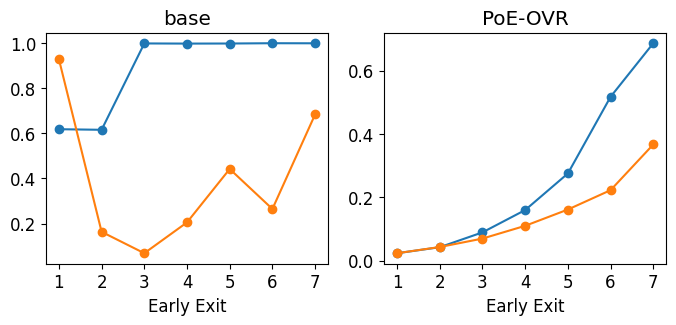

In [44]:
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
early_exits = [i + 1 for i in range(L)]

ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[0].set_xticks(early_exits)
ax[0].set_title('base')


ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)
ax[1].set_title('PoE-OVR')

plt.savefig(f'figures/figure_3_{PLOT_TYPE}.pdf', dpi=1200)
plt.show()

# Figure 4

In [2]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [3]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [4]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [5]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [8]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')

1 0.9981292
2 0.99859756
3 0.99938256
4 0.9993652
5 0.9995924
6 0.99978995
7 0.9996922
1 0.9777749
2 0.9666155
3 0.9553115
4 0.9454833
5 0.94010705
6 0.9426052
7 0.95646924
1 0.9753244
2 0.95950496
3 0.94436395
4 0.94402516
5 0.9521563
6 0.97183996
7 0.99058753


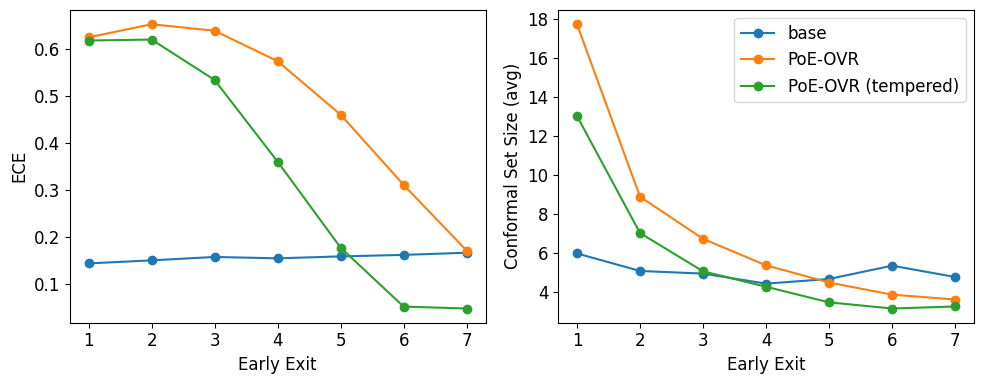

In [12]:
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for _probs, label in zip([probs, probs_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized_tempered], ['base', 'PoE-OVR', 'PoE-OVR (tempered)']):
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(list(range(1, L + 1)), ece, marker='o', label=label)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('ECE')


for _sizes, label in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered], ['base', 'PoE-OVR', 'PoE-OVR (tempered)']):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].legend()

plt.tight_layout()
plt.savefig(f'figures/figure_4.pdf', dpi=1200)
plt.show()